# Final Notebook for Submission
### Author: Veronica De Santos Quezada

## Who’s Most at Risk? Social Demographics and Traffic Collisions in the City of Los Angeles
This notebook includes our project analysis for TIMS pedestrian and bicycle collisions.

#### Data Sources & Geographic Information
- **American Community Survey (ACS) 2015-2029 (5-Year Estimates) on Age**
- **2015 - 2019 UC Berkeley - TIMS Pedestrian and Bicycle Collisions**

## Tools and Datasets

In [1]:
# data exploration 
import pandas as pd

# merge data 
import geopandas as gpd

# basemaps
import contextily as ctx

# spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps  

# importing for plots and tables 
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# upload all data 

# importing census tracts
la_tracts = gpd.read_file('data_final/cityLA.zip')

#importing median age data
age = pd.read_csv('data_final/age_dataset.csv')

#importing TIMS pedestrian and bicycle collisions
collisions = pd.read_csv('data_final/pedbike_tims.csv')

#importing total population data
population = pd.read_csv('data_final/Total Population.csv')

#importing city of la boundary
boundary = gpd.read_file("data_final/City_Boundary.geojson") 

/tmp/ipykernel_1706/239268642.py:10: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv('data_final/pedbike_tims.csv')


## Converting Data Types

In [3]:
# review Geo_FIPS for leading zero
age.Geo_FIPS.head()

0    6037101110
1    6037101122
2    6037101210
3    6037101220
4    6037101300
Name: Geo_FIPS, dtype: int64

In [4]:
# convert Geo_FIPS, state, and county data type from integer to string to include leading zero 
age = pd.read_csv('data_final/age_dataset.csv',
     dtype=
                 {'Geo_FIPS': str, 
                  'Geo_STATE': str, 
                  'Geo_COUNTY': str })

In [5]:
# check for leading zero 
age.head(2)

Geo_FIPS           Geo_GEOID              Geo_NAME  \
0  06037101110  14000US06037101110  Census Tract 1011.10   
1  06037101122  14000US06037101122  Census Tract 1011.22   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Census Tract 1011.10, Los Angeles County, Cali...         ca         140   
1  Census Tract 1011.22, Los Angeles County, Cali...         ca         140   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE  ... SE_A01001_004  \
0            0      ACSSF          3871        06  ...           200   
1            0      ACSSF          3872        06  ...           234   

   SE_A01001_005  SE_A01001_006  SE_A01001_007  SE_A01001_008  SE_A01001_009  \
0            132            291            652            555            580   
1             12            289            535            211            568   

   SE_A01001_010  SE_A01001_011  SE_A01001_012  SE_A01001_013  
0            604            430            219             78  
1            693            417            219             44  

[2 rows x 25 columns]

In [6]:
# checking state and county
print(age.Geo_STATE.head(2))     
print(age.Geo_COUNTY.head(2))

0    06
1    06
Name: Geo_STATE, dtype: object
0    037
1    037
Name: Geo_COUNTY, dtype: object


## Cleaning and Reorganizing the data

In [7]:
# find unnecessary columns with zero values 
age.columns[age.isna().all()].tolist()

[]

In [8]:
# seems like the age dataset has no zero values, but I will still delete uncessary columns 
age = age.dropna(axis=1,how="all")

In [9]:
# Create a new dataframe with selected columns
columns_to_keep = [
    'Geo_FIPS',
    'Geo_STATE',
    'Geo_COUNTY',
    'Geo_TRACT',
    'SE_A01001_001',
    'SE_A01001_002',
    'SE_A01001_003',
    'SE_A01001_004',
    'SE_A01001_005',
    'SE_A01001_006',
    'SE_A01001_007',
    'SE_A01001_008',
    'SE_A01001_009',
    'SE_A01001_010',
    'SE_A01001_011',
    'SE_A01001_012',
    'SE_A01001_013'
]

# Select only the specified columns
age = age[columns_to_keep]

In [10]:
# changing ACS column names to category names
column_rename_map = {
    'SE_A01001_001': 'Total Population',
    'SE_A01001_002': 'Under 5 Years',
    'SE_A01001_003': '5 to 9 Years',
    'SE_A01001_004': '10 to 14 Years',
    'SE_A01001_005': '15 to 17 Years',
    'SE_A01001_006': '18 to 24 Years',
    'SE_A01001_007': '25 to 34 Years',
    'SE_A01001_008': '35 to 44 Years',
    'SE_A01001_009': '45 to 54 Years',
    'SE_A01001_010': '55 to 64 Years',
    'SE_A01001_011': '65 to 74 Years',
    'SE_A01001_012': '75 to 84 Years',
    'SE_A01001_013': '85 Years and Over'
}

In [11]:
# Rename the columns in age
age = age.rename(columns=column_rename_map)

In [12]:
# Define new age groupings
age['Children & Adolescents (0-17)'] = age[['Under 5 Years', '5 to 9 Years', '10 to 14 Years', '15 to 17 Years']].sum(axis=1)
age['Young Adults (18-34)'] = age[['18 to 24 Years', '25 to 34 Years']].sum(axis=1)
age['Middle-Aged Adults (35-64)'] = age[['35 to 44 Years', '45 to 54 Years', '55 to 64 Years']].sum(axis=1)
age['Older Adults (65 and Over)'] = age[['65 to 74 Years', '75 to 84 Years', '85 Years and Over']].sum(axis=1)

# Select only relevant columns (keep geographic identifiers and new age groups)
age_grouped_combined = age[['Geo_FIPS', 'Geo_STATE', 'Geo_COUNTY', 'Geo_TRACT', 'Total Population',
                                 'Children & Adolescents (0-17)', 'Young Adults (18-34)',
                                 'Middle-Aged Adults (35-64)', 'Older Adults (65 and Over)']]

In [13]:
# renaming my dataset
age_final = age_grouped_combined

#### Adding a Column for Most Prevalent Age Group per Census Tract

In [14]:
# Selecting the age groups for determining prevalence
broad_age_columns = [
    'Children & Adolescents (0-17)', 
    'Young Adults (18-34)', 
    'Middle-Aged Adults (35-64)', 
    'Older Adults (65 and Over)'
]

# Finding the most prevalent broad age group for each census tract
age['Most_Prevalent_Age_Group'] = age[broad_age_columns].idxmax(axis=1)

# Check the results
print(age[['Geo_FIPS', 'Most_Prevalent_Age_Group']].head())  # Display the first few rows

      Geo_FIPS    Most_Prevalent_Age_Group
0  06037101110  Middle-Aged Adults (35-64)
1  06037101122  Middle-Aged Adults (35-64)
2  06037101210  Middle-Aged Adults (35-64)
3  06037101220  Middle-Aged Adults (35-64)
4  06037101300  Middle-Aged Adults (35-64)


In [15]:
age.head(2)

Geo_FIPS Geo_STATE Geo_COUNTY  Geo_TRACT  Total Population  \
0  06037101110        06        037     101110              4283   
1  06037101122        06        037     101122              3405   

   Under 5 Years  5 to 9 Years  10 to 14 Years  15 to 17 Years  \
0            283           259             200             132   
1             78           105             234              12   

   18 to 24 Years  ...  45 to 54 Years  55 to 64 Years  65 to 74 Years  \
0             291  ...             580             604             430   
1             289  ...             568             693             417   

   75 to 84 Years  85 Years and Over  Children & Adolescents (0-17)  \
0             219                 78                            874   
1             219                 44                            429   

   Young Adults (18-34)  Middle-Aged Adults (35-64)  \
0                   943                        1739   
1                   824                        1472   

   Older Adults (65 and Over)    Most_Prevalent_Age_Group  
0                         727  Middle-Aged Adults (35-64)  
1                         680  Middle-Aged Adults (35-64)  

[2 rows x 22 columns]

## Merge

###  Merging the City of LA census tracts with LA County census data for our project area

In [16]:
# Importing library
import pandas as pd

In [17]:
# I will use geographical data, importing geopandas
import geopandas as gpd

In [18]:
# Upload my data
cityofla=gpd.read_file('data_final/cityLA.zip')

In [19]:
# add a FIPS column
# creating a new column so that I can merge the shapefile and census tracts 

cityofla['Geo_FIPS'] = '06' + '037' + cityofla['TRACTCE']

In [20]:
# checking new column was made 
cityofla.head(2)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  AWATER     INTPTLAT  \
0  Census Tract 1011.10  G5020        S  1142401.0     0.0  +34.2594737   
1  Census Tract 1011.22  G5020        S  2644045.0     0.0  +34.2677213   

       INTPTLON   Shape_Leng   Shape_Le_1    Shape_Area  \
0  -118.2929869  4585.520052  4585.520052  1.142400e+06   
1  -118.2901465  9652.233049  9652.233049  2.644046e+06   

                                            geometry     Geo_FIPS  
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  06037101110  
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...  06037101122

In [21]:
# need to merge by creating a new dataframe
la_age =cityofla.merge(age_final,on="Geo_FIPS")

## Function and Loop for Age Distribution in the City of Los Angeles

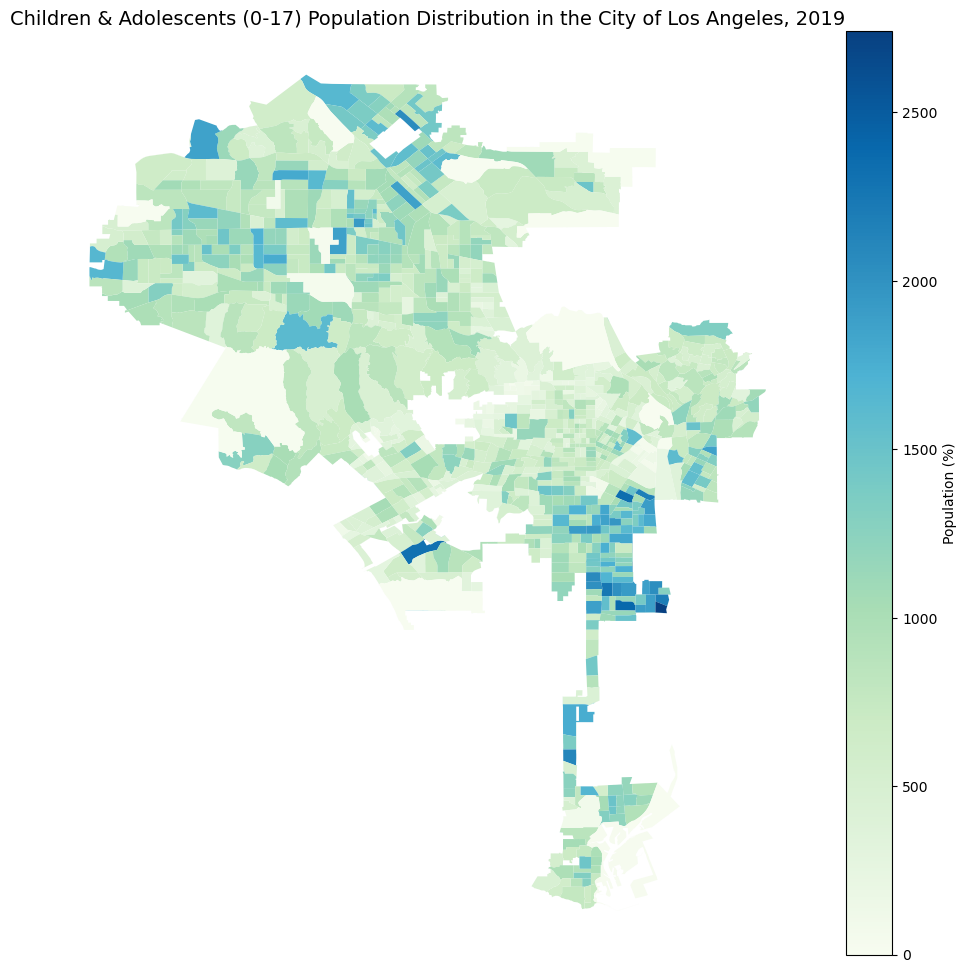

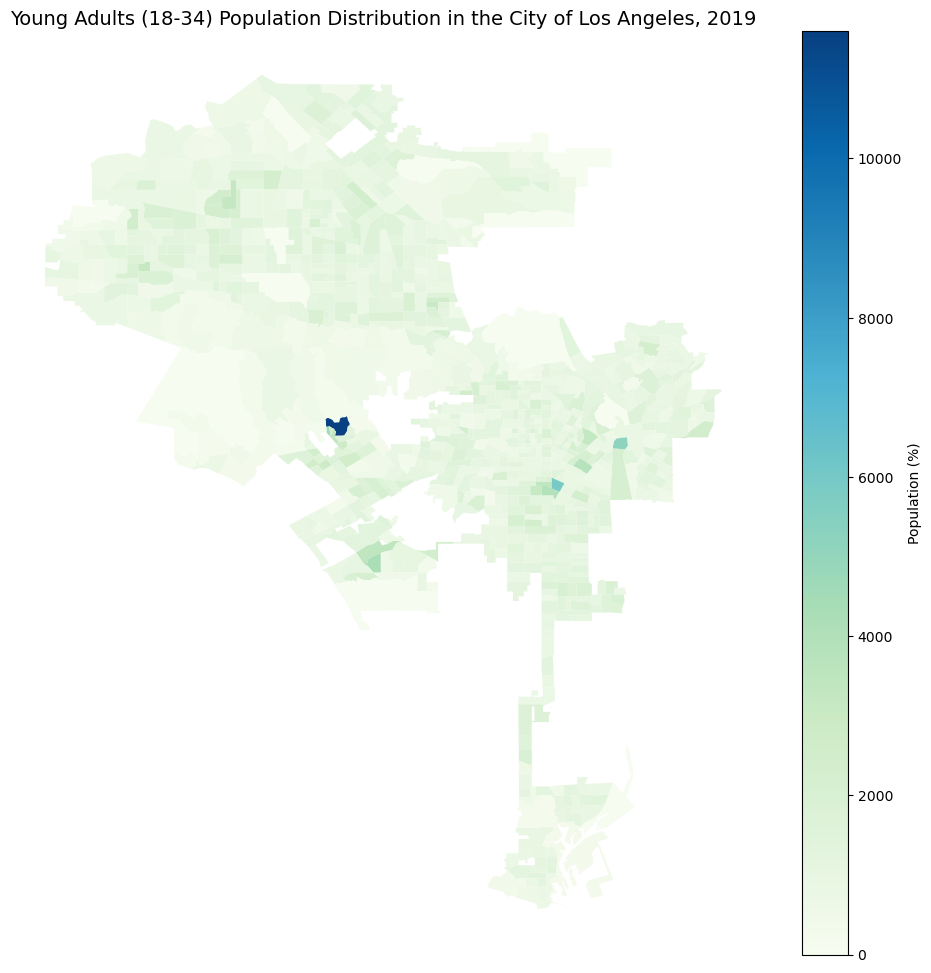

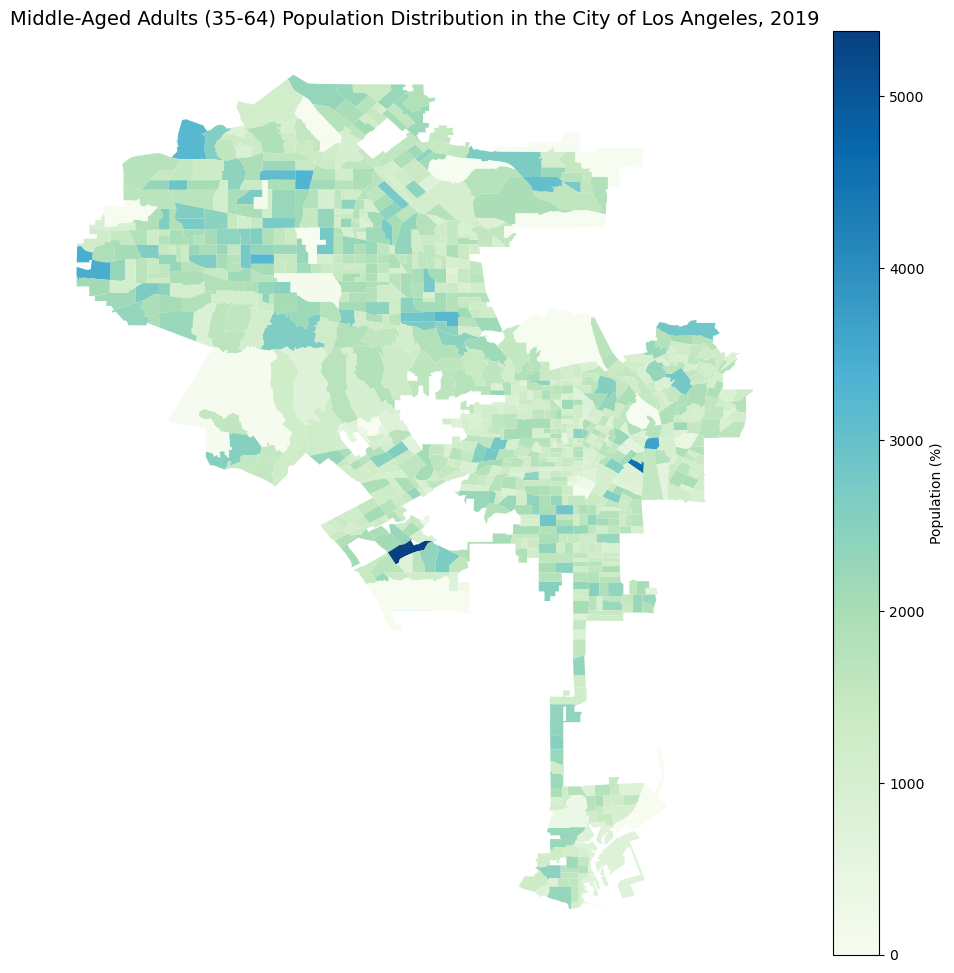

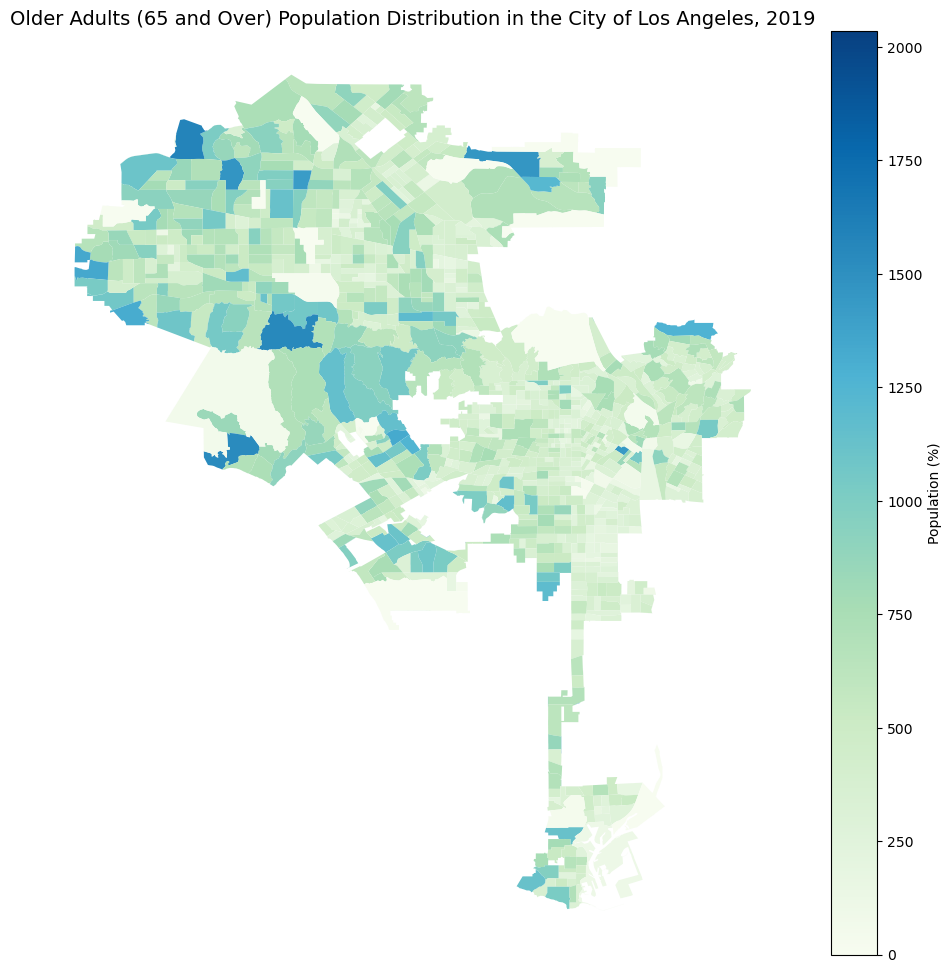

In [37]:
import matplotlib.pyplot as plt

# Function to generate age distribution maps
def plot_age_maps(data, columns, title_prefix):  
    
    for column in columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        
        # Plot census tracts with the selected age group percentage
        la_age.plot(ax=ax, column=column, legend=True, cmap='GnBu',
                    legend_kwds={"label": "Population (%)", "orientation": "vertical"})
        
        ax.axis('off')
        ax.set_title(f"{column} {title_prefix} in the City of Los Angeles, 2019", fontsize=14)
        ax.set_aspect('equal') #helps to fix the tilted maps. BUT SOMETIMES IT WORKS SOMETIMES IT DOESN'T.

# Use the age categories
age_map = [
    'Children & Adolescents (0-17)',
    'Young Adults (18-34)',
    'Middle-Aged Adults (35-64)',
    'Older Adults (65 and Over)'
]

# Loop!
plot_age_maps(la_age, age_map, "Population Distribution")


## Charts for Age Distribution in the City of Los Angeles

In [23]:
# Create a DataFrame for the age group data
age_bar = pd.DataFrame({
    'Age Group': ['Children & Adolescents (0-17)', 'Young Adults (18-34)', 
                  'Middle-Aged Adults (35-64)', 'Older Adults (65 and Over)'],
    'Population': [978971, 1301147, 1833051, 607531]
})

# Plot the bar chart
import plotly.express as px
fig = px.bar(age_bar, 
             x='Age Group', 
             y='Population', 
             title='Age Group Population in the City of Los Angeles',
             labels={'Population': 'Population Count', 'Age Group': 'Age Categories'},
             color='Age Group',
             color_discrete_map={
                 'Children & Adolescents (0-17)': '#1f77b4',  # Blue
                 'Young Adults (18-34)': '#ff7f0e',  # Orange
                 'Middle-Aged Adults (35-64)': '#2ca02c',  # Green
                 'Older Adults (65 and Over)': '#d62728'  # Red
             }) 

# Set the background to transparent
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)'  # Transparent outer background
)

fig.update_traces(marker_line_width=0, textposition='outside')

fig.show()

## Examining Transportation Injury Mapping System (TIMS) Dataset on Pedestrian and Bicycle Collisions in the City of Los Angeles (2015-2019)

In [24]:
import matplotlib.pyplot as plt
tims = pd.read_csv('data_final/pedbike_tims.csv')

/tmp/ipykernel_1706/691663044.py:2: DtypeWarning:

Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.



In [25]:
tims.head(2)

CASE_ID  ACCIDENT_YEAR   PROC_DATE  JURIS COLLISION_DATE  COLLISION_TIME  \
0  6292270           2015  2015-06-11   1942     2015-05-25            2145   
1  6292319           2015  2017-04-25   9590     2015-02-23             434   

  OFFICER_ID REPORTING_DISTRICT  DAY_OF_WEEK  CHP_SHIFT  ...  COUNT_MC_KILLED  \
0      38124               1375            1          5  ...                0   
1      20617                NaN            1          3  ...                0   

   COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP  LATITUDE  LONGITUDE  \
0                 0            -               -        NaN        NaN   
1                 0            -               -   34.03387 -118.22002   

        COUNTY         CITY     POINT_X    POINT_Y  
0  LOS ANGELES  LOS ANGELES -118.252130  33.992984  
1  LOS ANGELES  LOS ANGELES -118.220705  34.034132  

[2 rows x 80 columns]

In [26]:
# need to plot, so get
tims = gpd.GeoDataFrame(tims, 
                         crs ='EPSG:4326', 
                         geometry=gpd.points_from_xy(tims.POINT_X, tims.POINT_Y))

In [27]:
# checking tims projection
print("tims", tims.crs)

tims EPSG:4326


In [28]:
# checking tims projection
print("la_age", la_age.crs)

la_age PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]


In [29]:
# checking tims projection
print("la_age", la_age.crs)
la_age = la_age.to_crs(epsg=4326)

la_age PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]


<Axes: >

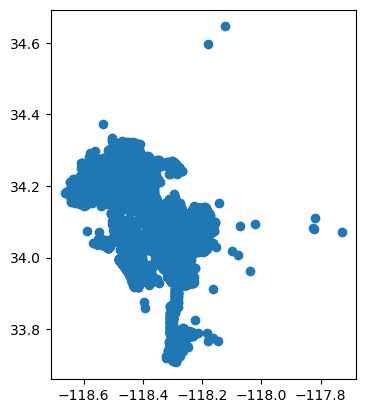

In [30]:
tims.plot()

In [31]:
tims = tims.dropna(subset=['geometry'])

In [32]:
tims.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 81 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CASE_ID                  25059 non-null  int64   
 1   ACCIDENT_YEAR            25059 non-null  int64   
 2   PROC_DATE                25059 non-null  object  
 3   JURIS                    25059 non-null  int64   
 4   COLLISION_DATE           25059 non-null  object  
 5   COLLISION_TIME           25059 non-null  int64   
 6   OFFICER_ID               25035 non-null  object  
 7   REPORTING_DISTRICT       24440 non-null  object  
 8   DAY_OF_WEEK              25059 non-null  int64   
 9   CHP_SHIFT                25059 non-null  int64   
 10  POPULATION               25059 non-null  int64   
 11  CNTY_CITY_LOC            25059 non-null  int64   
 12  SPECIAL_COND             25059 non-null  int64   
 13  BEAT_TYPE                25059 non-null  int64   
 14

In [33]:
#spatial join between collisions and city of LA 
boundary = gpd.read_file("data_final/City_Boundary.geojson") 
tims = gpd.sjoin(tims, boundary, predicate="within", how="inner")

In [34]:
#getting ped points 
ped = tims[tims["PEDESTRIAN_ACCIDENT"] == 'Y']

#getting bike points 
bike = tims[tims["BICYCLE_ACCIDENT"] == 'Y']

In [35]:
def plot_maps2(data, columns, title_prefix):  

     for column in columns:
        fig, ax = plt.subplots(figsize=(12, 12))
        la_age.plot(ax=ax,column=column,legend=True,cmap='GnBu',
             legend_kwds={"label": "Population (%)", "orientation": "vertical"})

        ped.plot(ax=ax, color='purple', markersize=1, alpha=0.6, label='Pedestrian Collisions')
        bike.plot(ax=ax, color='red', markersize=1, alpha=0.6, label='Bicycle Collisions')
        ax.legend(fontsize=12, loc="lower left", markerscale=8., bbox_to_anchor=(0.05, 0.05)) 

        ax.set_xlim(la_age.total_bounds[[0, 2]])  
        ax.set_ylim(la_age.total_bounds[[1, 3]])   
         
        ax.axis('off')
        ax.set_title (f" {title_prefix} {column} Population in the City of Los Angeles")

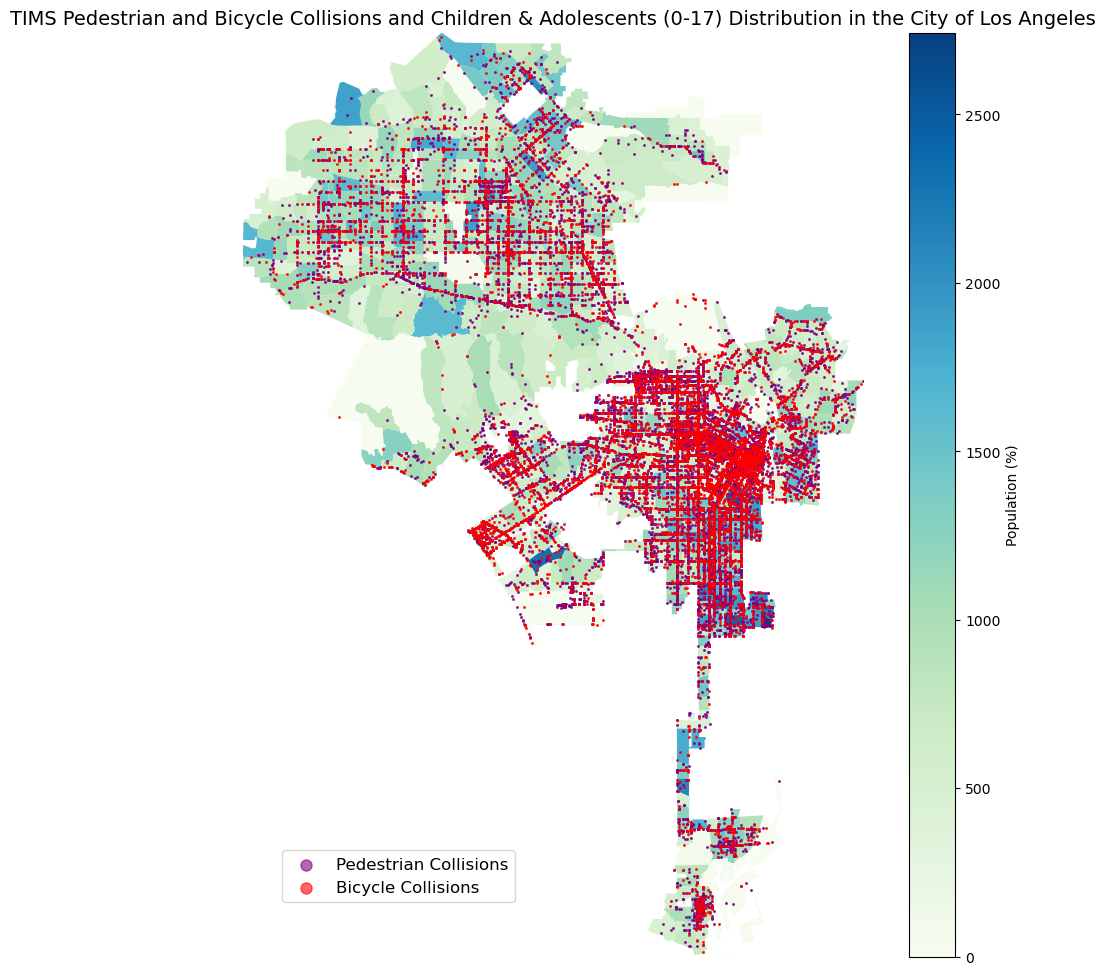

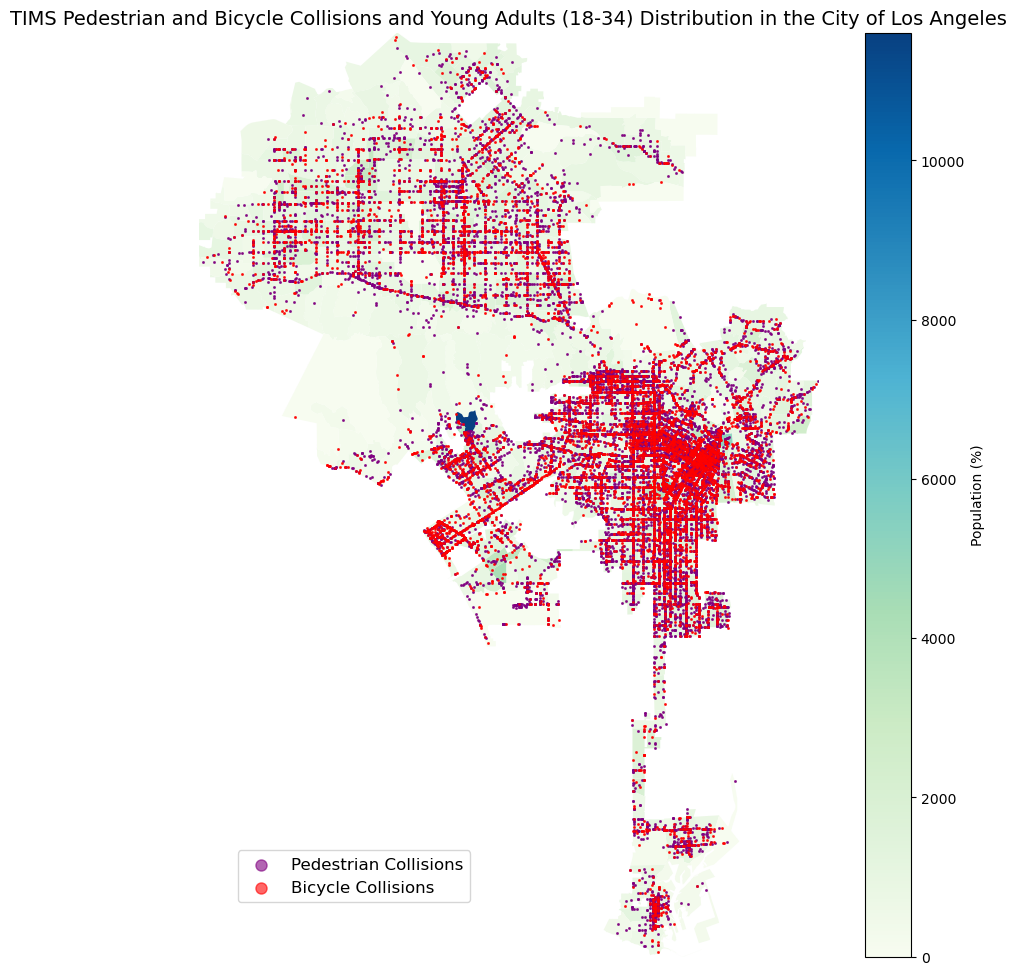

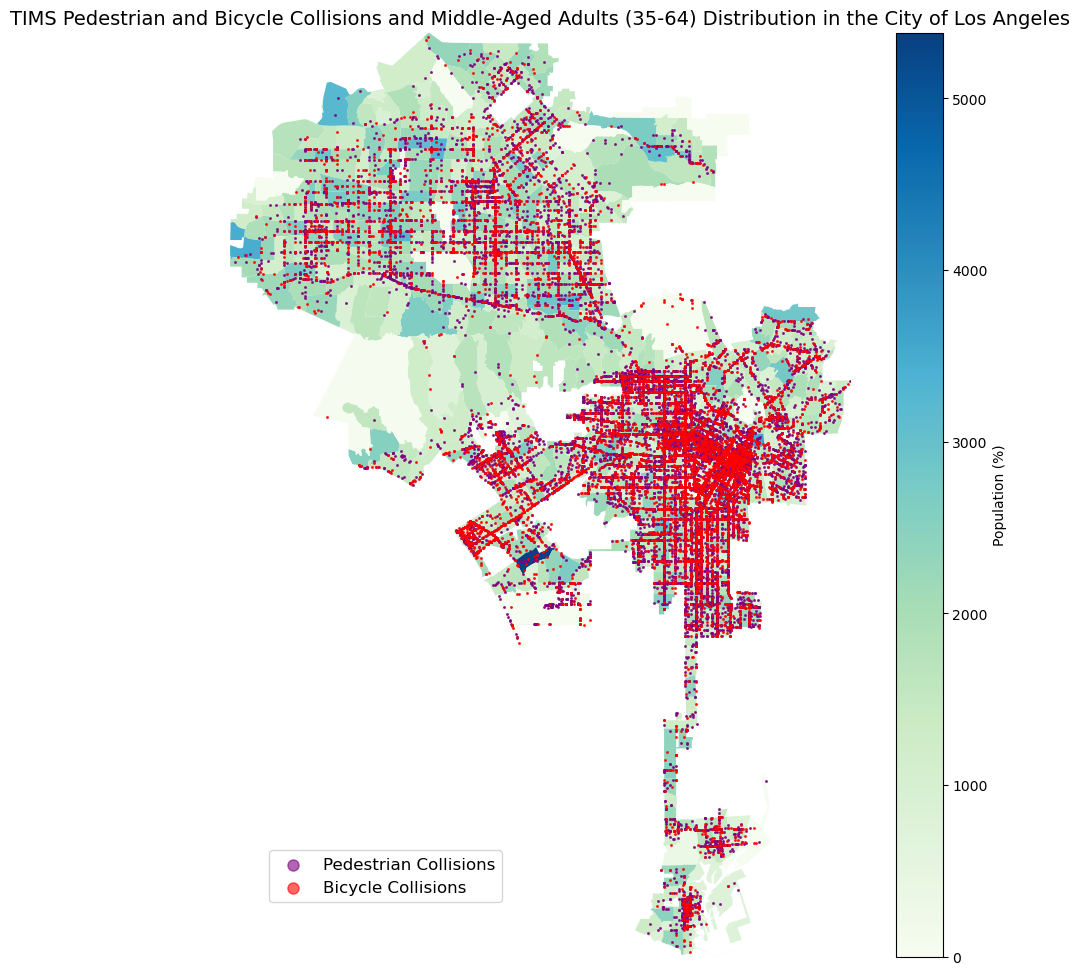

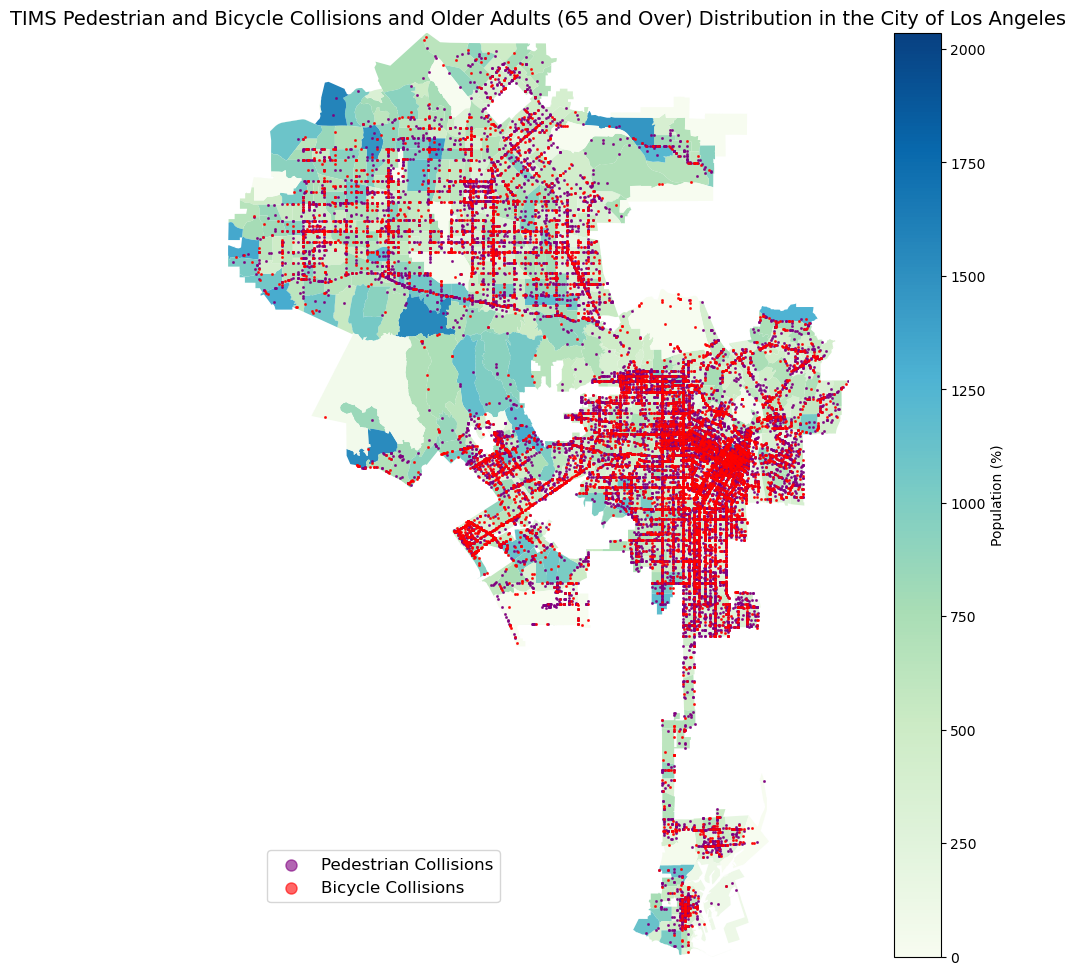

In [36]:
# Develop maps
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_maps2(data, columns, ped_data, bike_data, save_folder="Images"):  
    """
    Plots choropleth maps for age groups and overlays pedestrian & bicycle collisions.
    - `data`: GeoDataFrame with age distribution
    - `columns`: List of age distribution columns to map
    - `ped_data`: Pedestrian collision dataset (plotted in purple)
    - `bike_data`: Bicycle collision dataset (plotted in red)
    - `save_folder`: Directory to save the output images
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for column in columns:
        fig, ax = plt.subplots(figsize=(12, 12))

        # Plot age distribution
        data.plot(ax=ax, column=column, legend=True, cmap='GnBu',
                  legend_kwds={"label": "Population (%)", "orientation": "vertical"})

        # Plot pedestrian and bicycle collisions
        ped_data.plot(ax=ax, color='purple', markersize=1, alpha=0.6)
        bike_data.plot(ax=ax, color='red', markersize=1, alpha=0.6)

        # Manually define legend handles
        pedestrian = mpatches.Patch(color='purple', label="Pedestrian Collisions")
        bicycle = mpatches.Patch(color='red', label="Bicycle Collisions")

        # Add custom legend
        ped.plot(ax=ax, color='purple', markersize=1, alpha=0.6, label='Pedestrian Collisions')
        bike.plot(ax=ax, color='red', markersize=1, alpha=0.6, label='Bicycle Collisions')
        ax.legend(fontsize=12, loc="lower left", markerscale=8., bbox_to_anchor=(0.05, 0.05)) 

        # Fix map boundaries
        ax.set_xlim(data.total_bounds[[0, 2]])  
        ax.set_ylim(data.total_bounds[[1, 3]])   

        # Hide axes and set updated dynamic title
        ax.axis('off')
        formatted_column = column.replace("Children & Adolescents", "Children & Adolescents")
        formatted_column = formatted_column.replace("Young Adults", "Young Adults")
        formatted_column = formatted_column.replace("Middle-Aged Adults", "Middle-Aged Adults")
        formatted_column = formatted_column.replace("Older Adults", "Older Adults")
        
        ax.set_title(f"TIMS Pedestrian and Bicycle Collisions and {formatted_column} Distribution in the City of Los Angeles", fontsize=14)

        # Save the figure
        filename = f"{save_folder}/{column.replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

        # Display the figure
        plt.show()

# Run the function with correct inputs
plot_maps2(
    la_age, 
    ['Children & Adolescents (0-17)', 'Young Adults (18-34)', 'Middle-Aged Adults (35-64)', 'Older Adults (65 and Over)'],
    ped, 
    bike
)
